<a href="https://colab.research.google.com/github/Beauremontt/AGN-Flux-Timing-Analysis/blob/main/AGNFluxTimingAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Cells

## 1 Initialization

### 1.1 Modules & Functions

In [9]:
import numpy as np  # for math and arrays
import matplotlib.pyplot as plt  # for plotting

import requests  # for loading urls
from io import StringIO  # for passing text from url to numpy

from astropy.timeseries import LombScargle  # for the periodogram
from tabulate import tabulate  # for printing values of the LSP

from scipy.signal import find_peaks  # for intervals of peaks
from scipy.optimize import curve_fit  # for fitting peaks to Gaussian curves


# plots light curve and prints some preliminary info
def display_data(prefix):

  plt.subplots(1, 1, figsize=(12, 8))
  plt.errorbar(x/86400, y, yerr=dy, fmt='_k', ecolor='c', elinewidth=1)

  plt.title(f'{prefix} light curve for {flux_source}\n{band_label}', fontsize=24)
  plt.xlabel('MJD', fontsize=20)
  plt.ylabel('Flux', fontsize=20)
  plt.tick_params(labelsize=18)

  if lc_xlim != None: plt.xlim(lc_xlim)
  if lc_ylim != None: plt.ylim(lc_ylim)

  plt.show()

  print("\nNumber of data points =", NumData, "Start MJD =", x[0]/86400, "End MJD =", x[NumData - 1]/86400)
  print("Data Span =", Span/86400, "days",)
  print("Mean Spacing =", MeanSpacing/86400, "days")

### 1.2 Load data

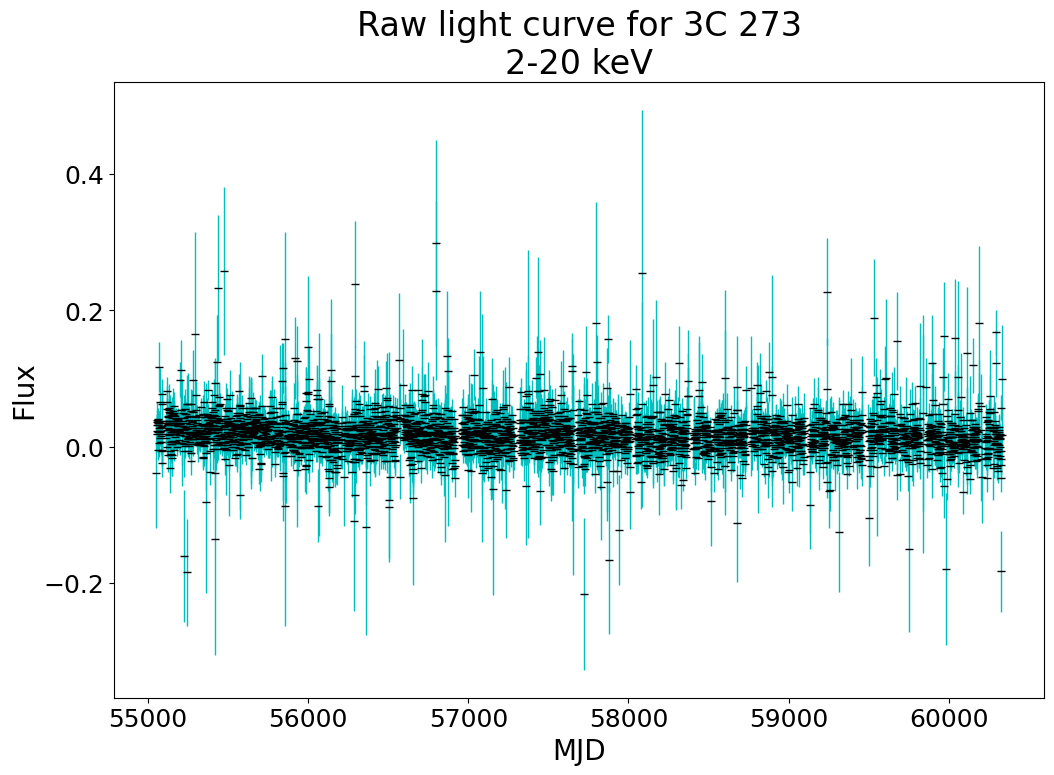


Number of data points = 4288 Start MJD = 55051.5 End MJD = 60332.5
Data Span = 5281.0 days
Mean Spacing = 1.231863774201073 days


In [10]:
# @title  { form-width: "40%" }

# url of the flux data
url = "http://maxi.riken.jp/star_data/J1229+020/J1229+020_g_lc_1day_all.dat" # @param {type:"string"}

# filename if you choose not to pull from url
filename = "" # @param {type:"string"}

# name of the AGN to display on plots
flux_source = "3C 273"  # @param {type:"string"}

# title of energy range of the flux measurements; prints below flux_source on plots
band_label = "2-20 keV"  # @param {type:"string"}

# which energy range to use; value is ordinal and depends on the archive
  # MAXI includes four different bands in each data file: 2-20, 2-4, 4-10, and 10-20 keV
energy_band = 1 # @param {type:"slider", min:1, max:4, step:1}
# the data column the chosen band corresponds to
flux_column = (energy_band-1)*2 + 1

# number of lines to skip at the beginning of the file
  # `np.genfromtxt` automatically skips commented lines (rows beginning with '#')
skip_header = 0  # @param {type:"integer"}

# number of lines to skip at bottom
skip_footer = 0  # @param {type:"integer"}

# whether or not to print the unfiltered light curve
display_raw = True  # @param {type:"boolean"}


# choose txt_content from inputs; prioritizes urls
if url != "":
  # fetch the content from the url
  response = requests.get(url)

  # create a text file-like with the data
  txt_content = StringIO(response.text)
elif filename != "": txt_content = filename
else: raise Exception("No flux data.")



# create an array from the text file
AGN = np.genfromtxt(txt_content, skip_header = skip_header, skip_footer = skip_footer)


# set up the values
x = 86400*AGN[:, 0]  # first column of the data set (MJD midpoint of observation in seconds)
y = AGN[:, flux_column]  # column of the data set (flux)
dy = AGN[:, flux_column + 1]  # next column of the data set (the uncertainty)

# get timespan and spacing of data
NumData = len(x)
Span = x[NumData - 1] - x[0]
MeanSpacing = Span / (NumData - 1)

# get averages of the error and the flux to find the percent error
Error = np.mean(dy)
Mean = np.mean(y)


# plot of light curve
if display_raw == True:

  # x,y limits on light curve, in the form "(lower, upper)"; leave blank or 'None' to not limit the graphs
  lc_xlim = None  # @param {type:"raw"}
  lc_ylim = None  # @param {type:"raw"}

  display_data("Raw")

## 2 Data & Analysis

### 2.1 Filter data

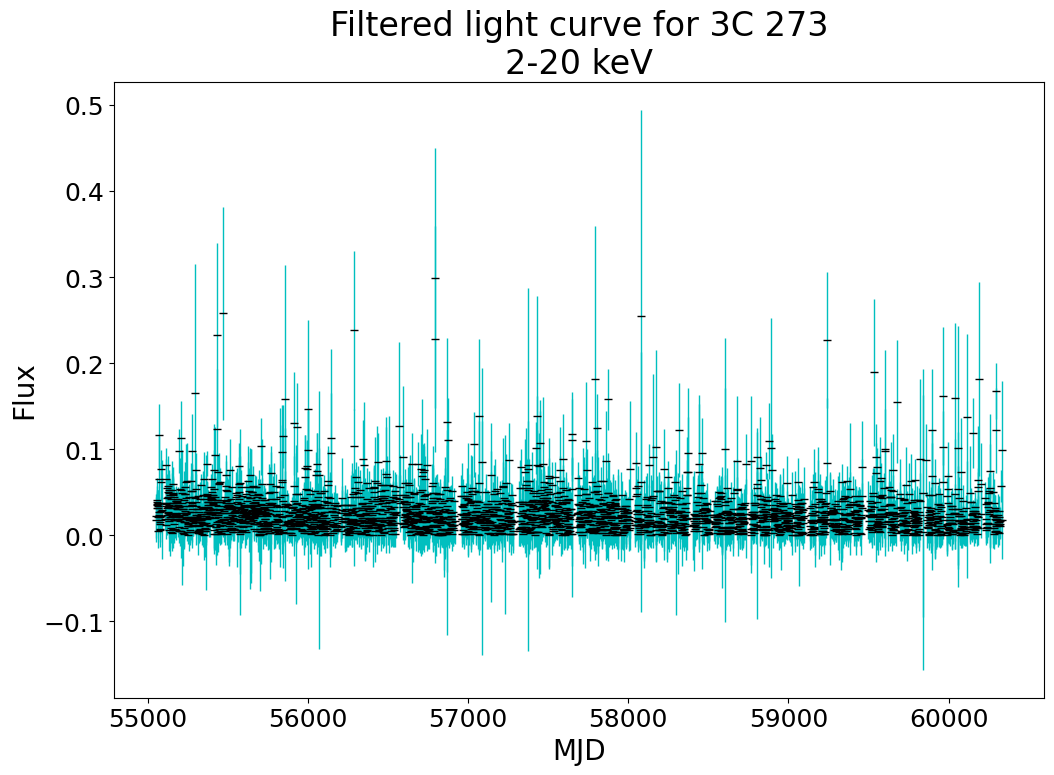


Number of data points = 3423 Start MJD = 55053.5 End MJD = 60332.5
Data Span = 5279.0 days
Mean Spacing = 1.5426651081239042 days


In [11]:
# @title  { form-width: "25%" }

# skips this cell if false
use_filter = True # @param {type:"boolean"}



if use_filter == True:

  # reset values
  x = 86400*AGN[:, 0]  # MJD (s)
  y = AGN[:, flux_column]  # Flux
  dy = AGN[:, flux_column + 1]  # uncertainty


  # determine data points to ignore
  rm = []
  for i in range(len(x)):
    if y[i] < 0:  # checks for negative flux
      rm.append(i)
      continue
    if dy[i] > 10**100:  # checks for low SNR flux PLACEHOLDER
      rm.append(i)

  # remove lines marked by filter
  x = np.delete(x, rm)
  y = np.delete(y, rm)
  dy = np.delete(dy, rm)


  # get timespan and spacing of data
  NumData = len(x)
  Span = x[NumData - 1] - x[0]
  MeanSpacing = Span / (NumData - 1)

  # get new averages of the error and the flux
  Error = np.mean(dy)
  Mean = np.mean(y)


  # x,y limits on light curve, in the form "(lower, upper)"; leave blank or 'None' to not limit the graphs
  lc_xlim = None  # @param {type:"raw"}
  lc_ylim = None  # @param {type:"raw"}

  # print filtered light curve
  display_data("Filtered")

### 2.2 Gap Histogram

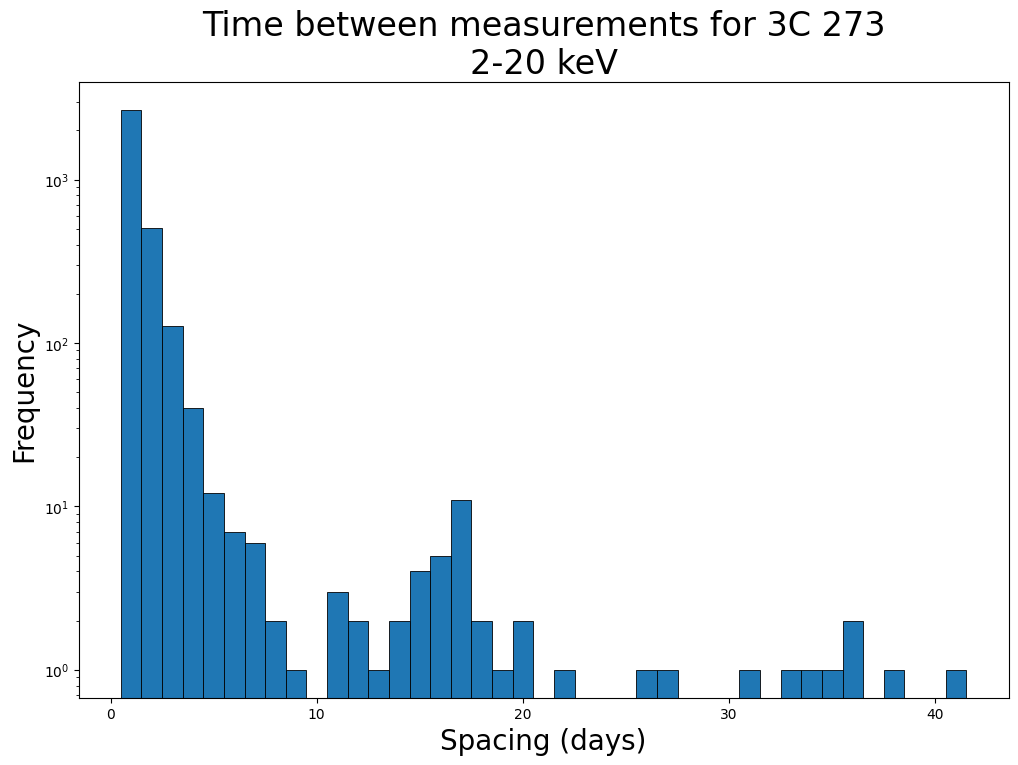

In [12]:
# get time gaps in days
delt_x = [(x[i] - x[i-1])/86400 for i in range(1, len(x))]

# make bins for day increments
max_gap = round(max(delt_x))
min_gap = round(min(delt_x))
bins = np.arange(min_gap, max_gap + 2) - 0.5


# plot histogram
plt.subplots(1,1,figsize=(12,8))
plt.hist(delt_x, bins=bins, align='mid', edgecolor='black', linewidth=25/len(bins))

plt.yscale('log')

plt.title(f'Time between measurements for {flux_source}\n{band_label}', fontsize=24)
plt.xlabel('Spacing (days)', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.show()

### 2.3 Gather Data

In [13]:
# @title  { form-width: "25%" }

# minimum_frequency, cuts off left of diagram
  #e.g., set to 2 to remove frequencies that would cover more than half the span
minif_factor = 2  # @param {type:"number"}

# nyquist_factor, "multiple of the average nyquist frequency used to choose the maximum frequency"
nyquist_factor = 2 # @param {type:"number"}

# whether to fully print
  # this is the lengthiest process and should be left off
verbose_table = False # @param {type:"boolean"}



# data for the periodogram
frequency, power = LombScargle(x, y, dy).autopower(minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)
period = 1/(frequency*86400)


# tabulate values of LSP
lsp_data = [np.array(range(len(power))), power, period, frequency]  # combine arrays


# print full frequency-ordered table
if verbose_table == True:
  data_str = [array.astype(str) for array in lsp_data]  # convert data to string
  formatted_data = np.insert(data_str, 0, ["LSP index", "power", "period (days)", "frequency (Hz)"], 1)  # insert headers
  print("Data as seen in power spectrum:\n", tabulate(formatted_data, numalign='left'), "\n")  # print as table


# find intervals of each peak
peaks, _ = find_peaks(power)  # returns indices of all maxima
pits, _ = find_peaks(-power)  # use inverted power for indices of minima


## print power-ordered table of just peaks
# get indices that would sort array of only the power maxima, then reverses it
sorted_indices = np.argsort(power[peaks])[::-1]

# sort peaks by power and get their indices
sorted_peak_indices = peaks[np.argsort(power[peaks])[::-1]]

# return data with only sorted peaks
sorted_data = [array[sorted_peak_indices] for array in lsp_data]

# convert to string
sorted_data_str = [array.astype(str) for array in sorted_data]

# insert headers
sorted_formatted_data = np.insert(sorted_data_str, 0, ["LSP index", "power", "period (days)", "frequency (Hz)"], 1)

# add a row to label each peak with its original index
sorted_peaks = [np.where(peaks == sorted_data[0][i])[0][0] for i in range(len(sorted_data[0]))]
row_peak_num = ["peaks index"] + sorted_peaks  # create another row with a header

# insert new row into second place
sorted_formatted_data = np.vstack([sorted_formatted_data[:1], row_peak_num, sorted_formatted_data[1:]])

print("\nPeaks in descending order of power:\n")
print(tabulate(sorted_formatted_data, numalign='left'))


Peaks in descending order of power:

--------------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ----------  ----------  -----------  -----------  -----------  ----------  -----------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ----------  -----------  -----------  -----------  -----------  ----------  ----------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ----------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ----------  -----------  -----------  -----------  -----------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  ---------

### 2.4 Power Spectrum

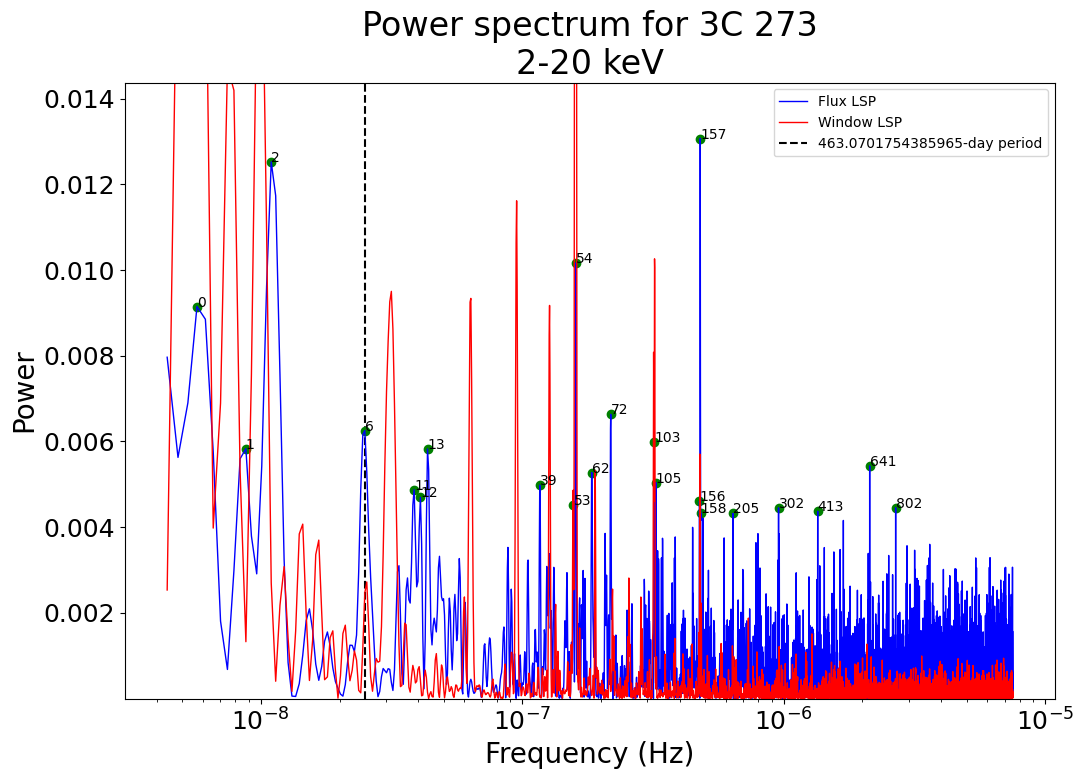

In [22]:
# @title  { form-width: "25%" }

# period in days to be plotted as a vertical line on the power spectrum
period_bar = 463.0701754385965 # @param {type:"raw"}
if period_bar != (0 or None): frequency_bar = 1/(period_bar*86400)



# set up values for Thomas test
yy = 0 * x + 1  #Need to set the y values to one, in order to have the y axis be zero
dyy = 0 * x + 42
ffrequency, ppower = LombScargle(x, yy, dyy).autopower(minimum_frequency = minif_factor/Span, nyquist_factor = nyquist_factor)


# plot of power spectrum
plt.subplots(1,1,figsize=(12,8))
plt.plot(frequency, power, 'b', linewidth=1, label='Flux LSP')
#plt.scatter(frequency, power, 'b', label='Flux LSP')
plt.plot(ffrequency, ppower,'r', linewidth=1, label='Window LSP')

plt.xscale('log')
plt.yscale('linear')

# plot vertical line for scrubbing
if period_bar != (0 or None):
  plt.vlines(frequency_bar, np.min((power, ppower)), np.max((power, ppower)), 'k', 'dashed', f'{period_bar}-day period', zorder=1)

# plot notable peaks
high_peaks = sorted_peaks[:round(0.01*len(peaks))]  # pick out peaks indices of top 1% of peaks
idx_high = peaks[high_peaks]  # peaks indices to LSP indices
plt.scatter(frequency[idx_high], power[idx_high], color='g')  # places green dots on graph
for i in range(len(idx_high)):  # label green dots with peaks index
  plt.text(frequency[idx_high[i]], power[idx_high[i]], str(high_peaks[i]))

# plot labels
plt.title(f'Power spectrum for {flux_source}\n{band_label}', fontsize=24)
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.tick_params(labelsize=18)
plt.legend()

# plot limits
  # give limits in the form "(lower, upper)", or leave blank
lsp_xlim = None  # @param {type:"raw"}
if lsp_xlim != None: plt.xlim(lsp_xlim)
lsp_ylim = (min(power), 1.1*max(power))  # @param {type:"raw"}
if lsp_ylim != None: plt.ylim(lsp_ylim)

plt.show()

### 2.5 Fit Peaks to Gaussian

Lower bound: 1    Index at peak: 3    Upper bound: 7


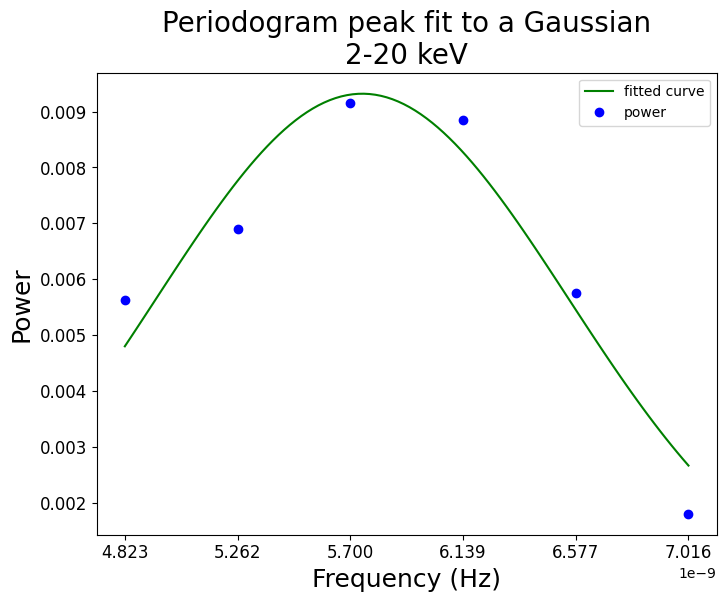


Peak power: 0.009320249304801992 

                Estimate     Uncertainty
--------------  -----------  -------------
frequency (Hz)  5.74726e-09  8.02035e-10
period (days)   2013.84      281.033


In [17]:
# @title  { form-width: "25%" }

# choose peak from labels on graph, or from 'peaks index' row of second table in 2.4
choose_peak = 0 # @param {type:"integer"}

# ensure the interval encloses the peak
if power[peaks[0]] > power[pits[0]]:
  interval_start = pits[choose_peak]
  interval_end = pits[choose_peak+1]
else:
  interval_start = pits[choose_peak-1]
  interval_end = pits[choose_peak]
print("Lower bound:", interval_start, "   Index at peak:", peaks[choose_peak], "   Upper bound:", interval_end)


# get data values
data_y = power[interval_start:interval_end]
data_x = frequency[interval_start:interval_end]

# define the Gaussian function
def Gauss(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# initial guess for parameters
init = [np.mean(data_x), np.std(data_x), np.max(data_y)]

# fit data to Gauss
params, covariance = curve_fit(Gauss, data_x, data_y, p0=init)

# get optimized parameters
mu, sigma, amplitude = params
mu_d = 1/(mu*86400)
sigma_d = sigma/mu * mu_d

# plot fitted curve and data
plt.subplots(1,1,figsize=(8,6))
gauss_x = np.linspace(data_x[0], data_x[-1], 100)
plt.plot(gauss_x, Gauss(gauss_x, mu, sigma, amplitude), 'g-', label="fitted curve")
plt.plot(data_x, data_y, 'bo', label="power")

# put labels on plot
plt.title(f"Periodogram peak fit to a Gaussian\n{band_label}", fontsize=20)
plt.xticks(np.linspace(min(data_x), max(data_x), 6))
plt.xlabel("Frequency (Hz)", fontsize=18)
plt.ylabel("Power", fontsize=18)
plt.tick_params(labelsize=12)
plt.legend()

# print results
plt.show()
print("\nPeak power:", amplitude, "\n")
print(tabulate([["frequency (Hz)"] + [mu, sigma], ["period (days)"] + [mu_d, sigma_d]], headers=["", "Estimate", "Uncertainty"], numalign='left'))

### 2.6 Analysis

In [16]:
# finds the maximum and the minimum of the periodogram columns
item = np.where(power == np.amax(power))[0]
fofmax = frequency[item][0]
pdmax = 1/(fofmax*86400)


# calculate False Alarm Probability [Horne & Baliunas, 1986]
B = len(power)
N_i = -6.392 + 1.193*B + 0.00098*B**2
mu_tot = np.mean(power)
sigma_tot = np.std(power)
Z = (np.max(power) - mu_tot)/sigma_tot
FAP = 1 - (1 - np.exp(-Z)) ** N_i
altFAP = 1 - (1 - np.exp(-Z)) ** (NumData/2)


# print analysis results
print("The count for frequency is:" , len(frequency))
print("The count for power is: " , B)

print("\nThe percent error is: ", ((Error/Mean)*100), "%")

print("\nMinimum  Power: ", np.min(power))
print("Maximum Power: ", np.max(power))
print("Index at max power = ", *item)

print("\nFrequency at Maximum Power", fofmax, "Hz")
print("Period at Maximum Power =", pdmax, "days")
if pdmax < 3/24: print("                        =", pdmax*1440, "minutes")
elif pdmax < 2: print("                        =", pdmax*24, "hours")

print("\nNumber of data points =", NumData)
print("Start MJD =", x[0]/86400, "  End MJD =", x[NumData - 1]/86400)
print("Data Span =", Span/86400, "days",)
print("Mean Spacing =", MeanSpacing/86400, "days")

print("\nMean power =", mu_tot)
print("Power standard deviation =", sigma_tot)

print("\nNumber of independent frequencies [HB86] =", N_i)

print("\nNyquist-limited frequencies =", NumData/2)
print("Z=", Z, "  False Alarm Probability =", FAP)
print("AltFAP (Nyquist) =", altFAP)

The count for frequency is: 17106
The count for power is:  17106

The percent error is:  83.6186854725321 %

Minimum  Power:  1.9622679736673048e-08
Maximum Power:  0.013068802264172638
Index at max power =  1083

Frequency at Maximum Power 4.792749749180891e-07 Hz
Period at Maximum Power = 24.149130832570908 days

Number of data points = 3423
Start MJD = 55053.5   End MJD = 60332.5
Data Span = 5279.0 days
Mean Spacing = 1.5426651081239042 days

Mean power = 0.0005893949140637307
Power standard deviation = 0.0006806298565925272

Number of independent frequencies [HB86] = 307163.99728

Nyquist-limited frequencies = 1711.5
Z= 18.33508658081092   False Alarm Probability = 0.003340542362923027
AltFAP (Nyquist) = 1.8644293417691138e-05
